In [5]:
# Python Project Template

### 1. Prepare Problem
#### a) Load libraries
#### b) Load dataset

### 2. Summarize Data
#### a) Descriptive statistics
#### b) Data visualizations

### 3. Prepare Data
#### a) Data Cleaning
#### b) Feature Selection
#### c) Data Transform

### 4. Evaluate Algorithms
#### a) Split-out validation dataset
#### b) Test options and evaluation metric
#### c) Spot check Algorithms

### 5. Improve Accuracy
#### a) Algorithm Tuning
#### b) Ensembles

### 6. Finalize Model 
#### a) Predictions on validation dataset
#### b) Create standalone model on entire training dataset
#### c) Save model for later use

This is the data set used by Gorman and Sejnowski in their study of the classification of sonar signals. The task is to train a network to discriminate between sonar signals bounced off a metal cylinder and those bounced off a roughly cylindrical rock

The data set contains the response metrics for 60 separate sonar frequency bins sent out against a known mine field (and known rocks). These frequencies are then labeled with the known object they were beaming the sound at.

### 1. Prepare Problem

#### a) Load libraries

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from pickle import dump
#from pickle import load

#### b) Load dataset

In [7]:
# Load dataset
filename = 'sonar-data.csv'
df = pd.read_csv(filename, header=None)
df.rename(columns=lambda x: f'freqbin_{x + 1:02d}' if isinstance(x, int) else x, inplace=True) # Rename columns by adding "freqbin_" before the numbers
df.rename(columns={'freqbin_61': 'target'}, inplace=True) # Rename the last column by adding "freqbin_" before the column name

In [8]:
df.tail()

,freqbin_01,freqbin_02,freqbin_03,freqbin_04,freqbin_05,freqbin_06,freqbin_07,freqbin_08,freqbin_09,freqbin_10,...,freqbin_52,freqbin_53,freqbin_54,freqbin_55,freqbin_56,freqbin_57,freqbin_58,freqbin_59,freqbin_60,target
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M
207,0.0260,0.0363,0.0136,0.0272,0.0214,0.0338,0.0655,0.1400,0.1843,0.2354,...,0.0146,0.0129,0.0047,0.0039,0.0061,0.0040,0.0036,0.0061,0.0115,M


### 2. Summarize Data

#### a) Descriptive statistics

In [9]:
# dimensions
print(df.shape)

(208, 61)


In [10]:
# types
print(df.dtypes)

freqbin_01    float64
freqbin_02    float64
freqbin_03    float64
freqbin_04    float64
freqbin_05    float64
               ...   
freqbin_57    float64
freqbin_58    float64
freqbin_59    float64
freqbin_60    float64
target         object
Length: 61, dtype: object


In [11]:
# descriptions
df.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
freqbin_01,208.0,0.029164,0.022991,0.0015,0.013350,0.02280,0.035550,0.1371
freqbin_02,208.0,0.038437,0.032960,0.0006,0.016450,0.03080,0.047950,0.2339
freqbin_03,208.0,0.043832,0.038428,0.0015,0.018950,0.03430,0.057950,0.3059
freqbin_04,208.0,0.053892,0.046528,0.0058,0.024375,0.04405,0.064500,0.4264
freqbin_05,208.0,0.075202,0.055552,0.0067,0.038050,0.06250,0.100275,0.4010


In [12]:
# class distribution
df.groupby('target').size()

target
M    111
R     97
dtype: int64

#### b) Data visualizations

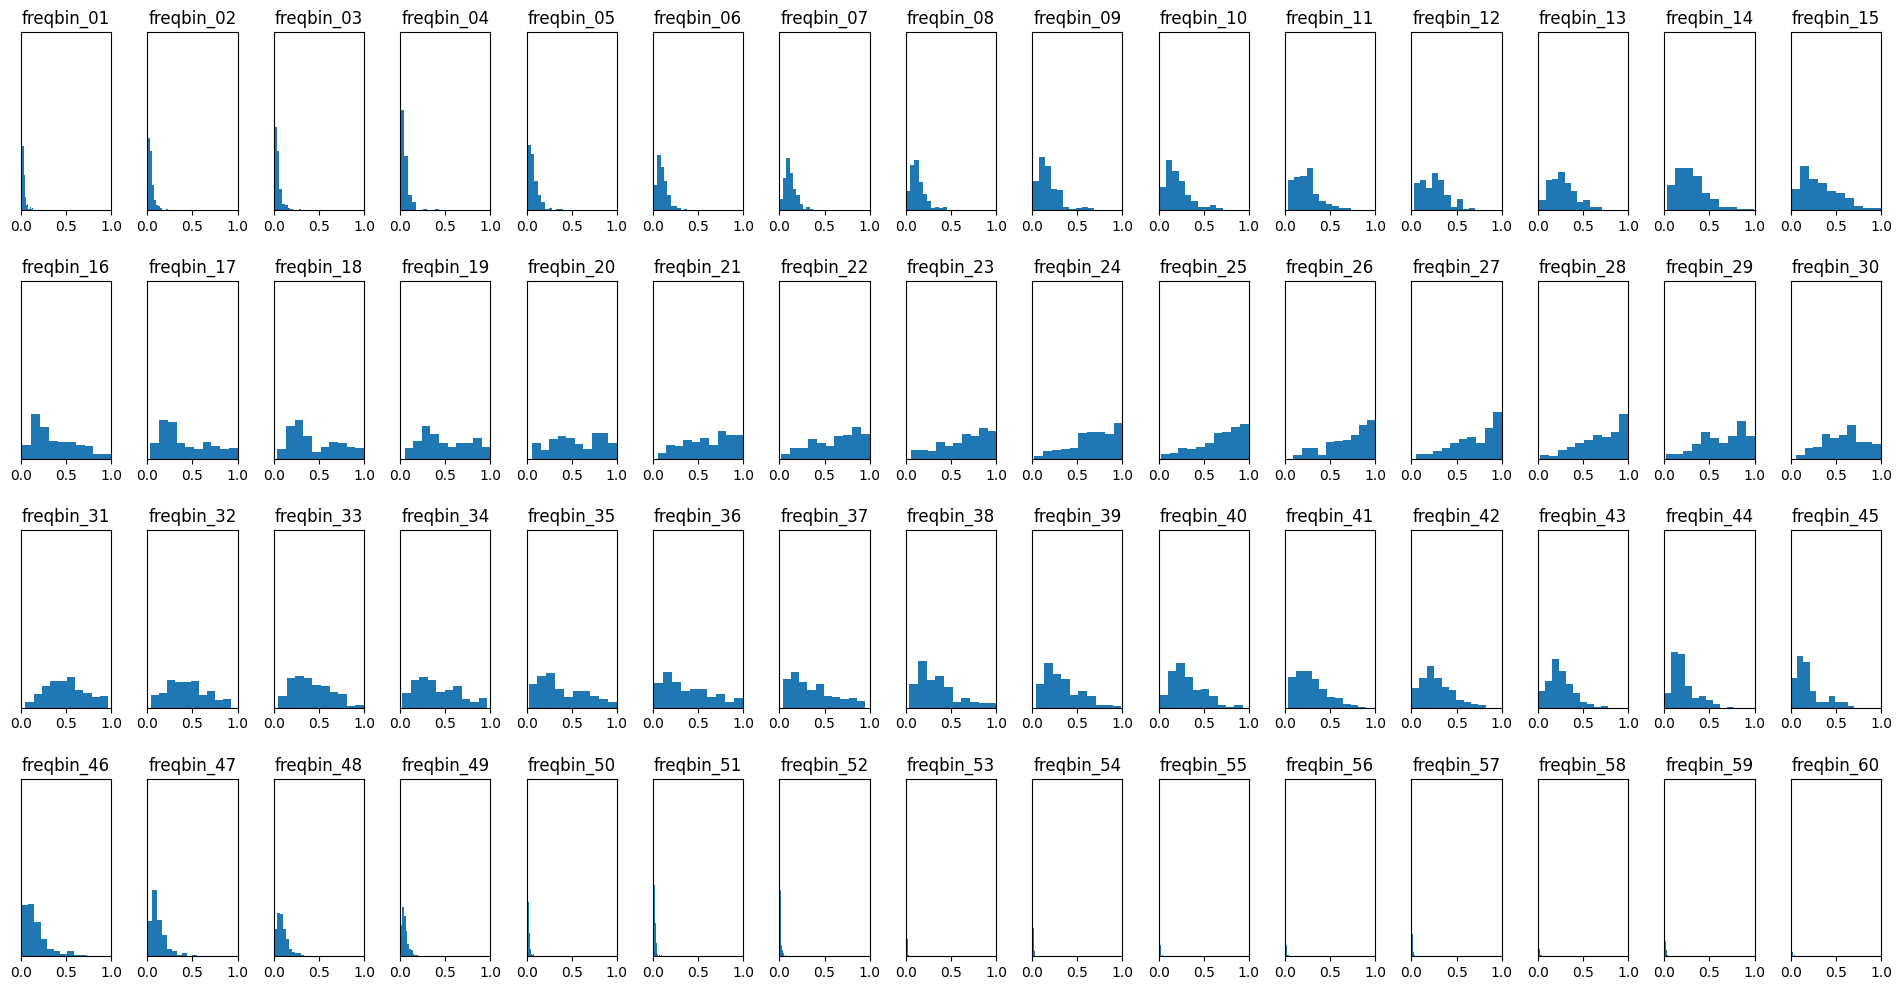

In [13]:
#plot histograms 

subplot_rows = 4
subplot_cols = 15

fig, axs = plt.subplots(subplot_rows, subplot_cols, figsize=(24, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Iterate through the subplots and plot the histograms
for i in range(subplot_rows):
    for j in range(subplot_cols):
        column_index = (i * subplot_cols) + j
        axs[i, j].set_xlim(0, 1)
        axs[i, j].set_ylim(0, 1)
        weights = np.ones_like(df.iloc[:, column_index]) / len(df.iloc[:, column_index]) # calculatin weight because the parameter 'density=True' in plt.hist doesnt work properly
        axs[i, j].set_yticks([])
        axs[i, j].hist(df.iloc[:, column_index], bins=10, weights=weights) # the parameter 'density=True' doesnt work as we think
        axs[i, j].set_title(f'{df.columns[column_index]}')

plt.show()

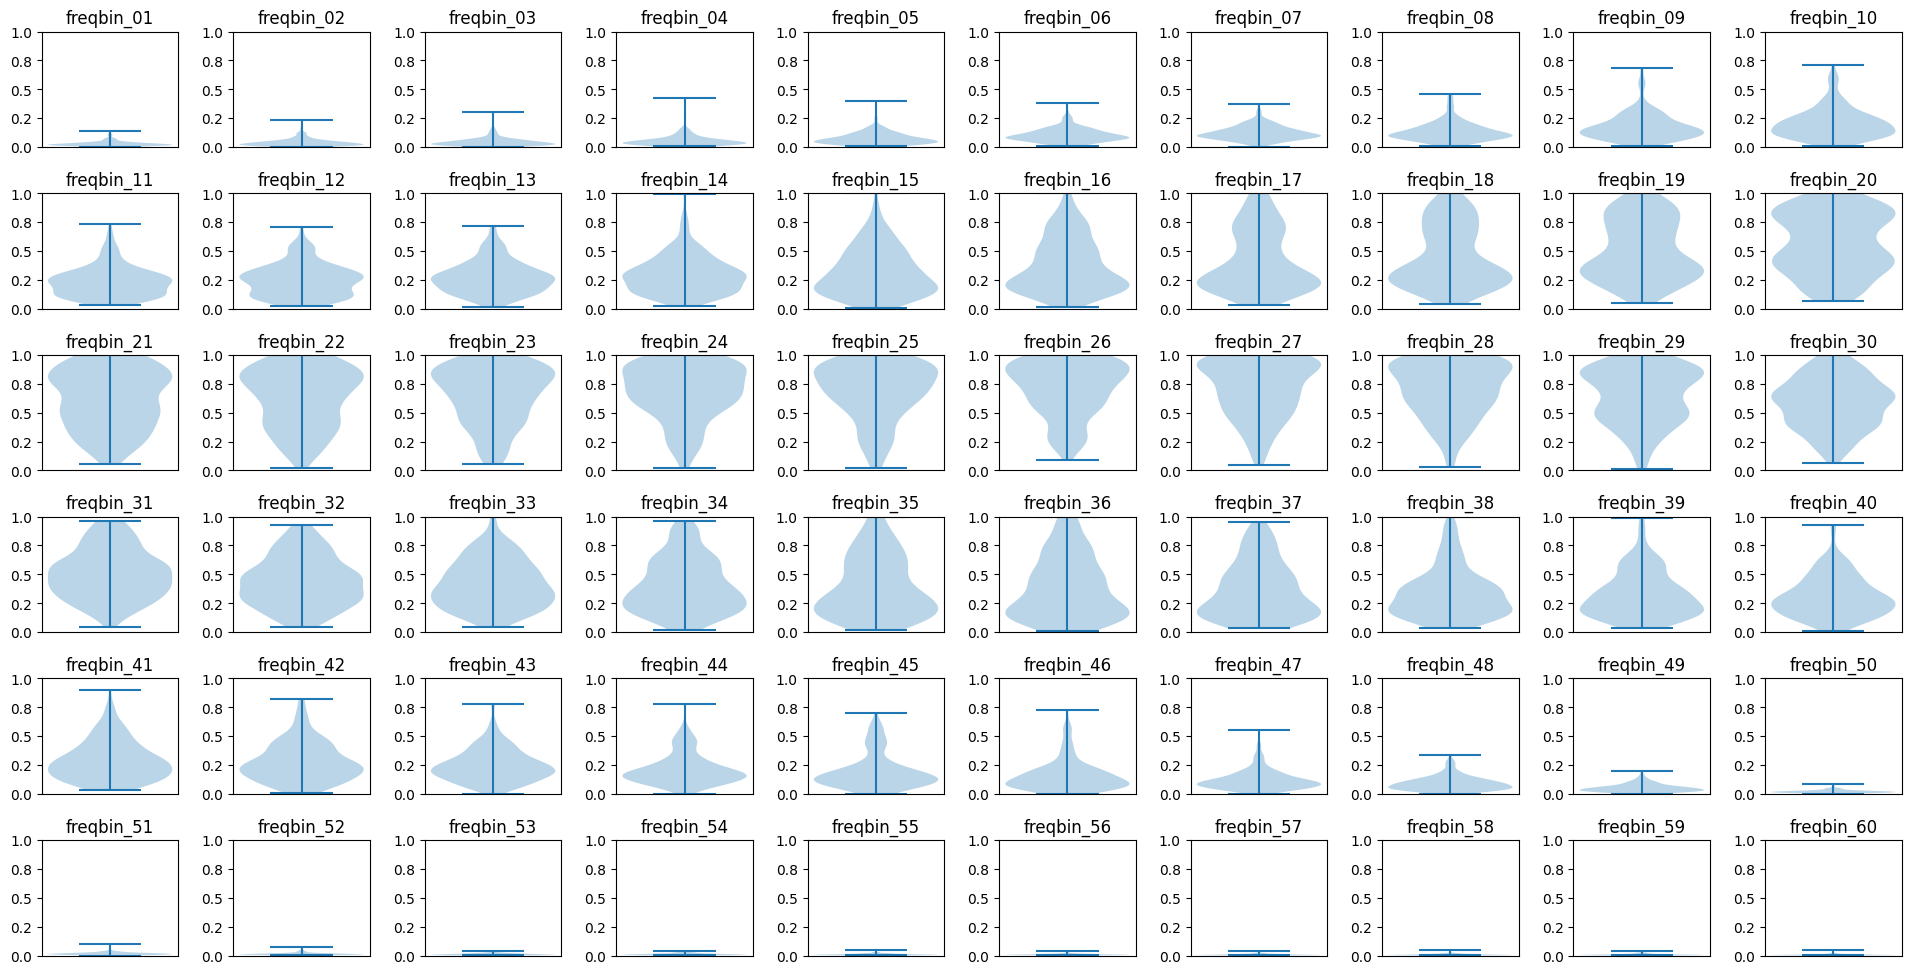

In [14]:
#plot boxplot 
fig, axs = plt.subplots(6, 10, figsize=(24, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)


# Iterate through the subplots and plot the histograms
for i in range(6):
    for j in range(10):
        column_index = i * 10 + j
        axs[i, j].set_xticks([])
        axs[i, j].set_ylim(0, 1)
        axs[i, j].violinplot(df.iloc[:, column_index])
        axs[i, j].set_title(f'{df.columns[column_index]}')
        axs[i, j].yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

plt.show()

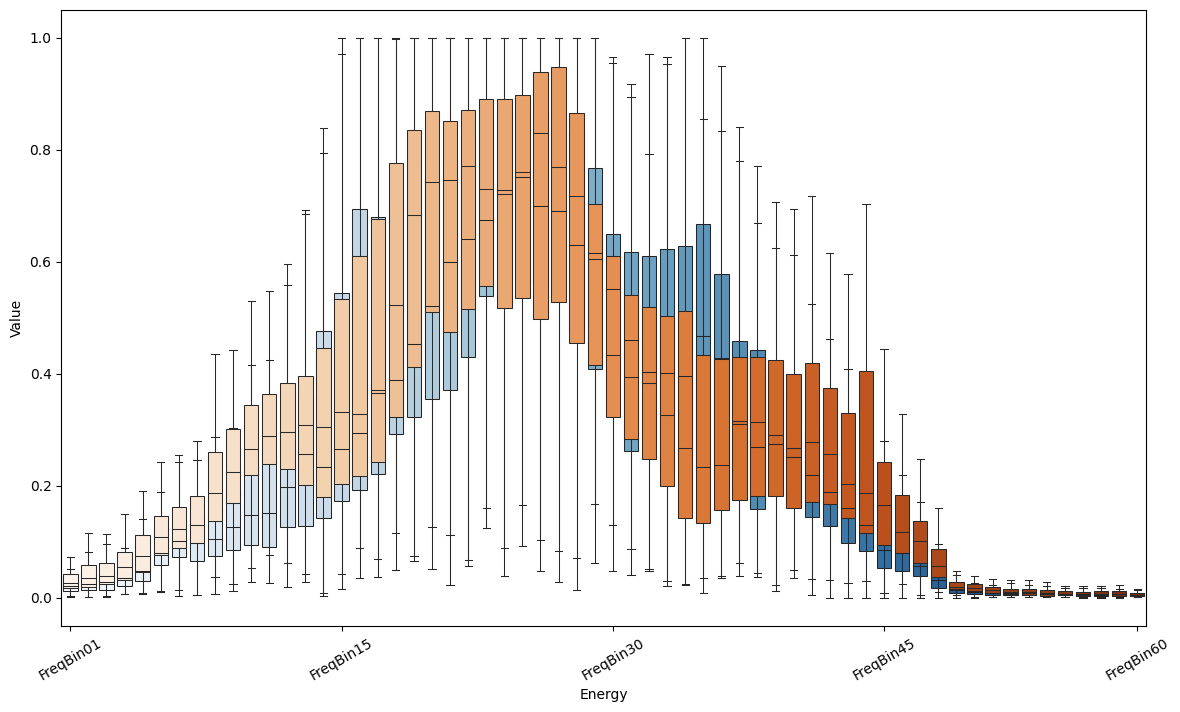

In [15]:
#
sonar_selected_r = df[df['target'] == 'R'].iloc[:, :-1]
sonar_selected_m = df[df['target'] == 'M'].iloc[:, :-1]

# Pivot the DataFrame
sonar_pivot_r = sonar_selected_r.melt(var_name='Energy', value_name='Value')
sonar_pivot_m = sonar_selected_m.melt(var_name='Energy', value_name='Value')

# Convert 'Energy' column to categorical
sonar_pivot_r['Energy'] = pd.Categorical(sonar_pivot_r['Energy'])
sonar_pivot_m['Energy'] = pd.Categorical(sonar_pivot_m['Energy'])

# Plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Energy', y='Value', hue='Energy', data=sonar_pivot_r, orient='v', palette='Blues', showfliers=False, linewidth=.75)
sns.boxplot(x='Energy', y='Value', hue='Energy', data=sonar_pivot_m, orient='v', palette='Oranges', showfliers=False, linewidth=.75)

plt.xticks([0, 15, 30, 45, 59], ['FreqBin01', 'FreqBin15', 'FreqBin30', 'FreqBin45', 'FreqBin60'], rotation=30)
plt.xlabel('Energy')
plt.ylabel('Value')
plt.show()

In [16]:
def corr_graph(df, txt):
    # plot correlation matrix
    correlations = df.corr()
    col_length = len(correlations.columns)

    # modifying it to only include values below the diagonal
    ones = np.ones(correlations.shape) # return a new array filled with ones of a given shape and type
    mask = np.tril(ones, k=-1).astype(np.bool) # lower triangle of an array + substitute 0 for False
    new_correlations = correlations.where(mask) # replace values where the condition is False

    # ploting
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(new_correlations, cmap='RdBu', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, col_length, 1)

    # Loop over data dimensions and create text annotations
    if txt == True:
        for i in range(col_length):
            for j in range(col_length):
                # Add text annotation only where mask is True (non-zero)
                if mask[i, j] == True:
                    text = ax.text(j, i, round(new_correlations.to_numpy()[i, j], 1),
                            ha="center", va="center", color="black", fontsize='small')
    plt.show()

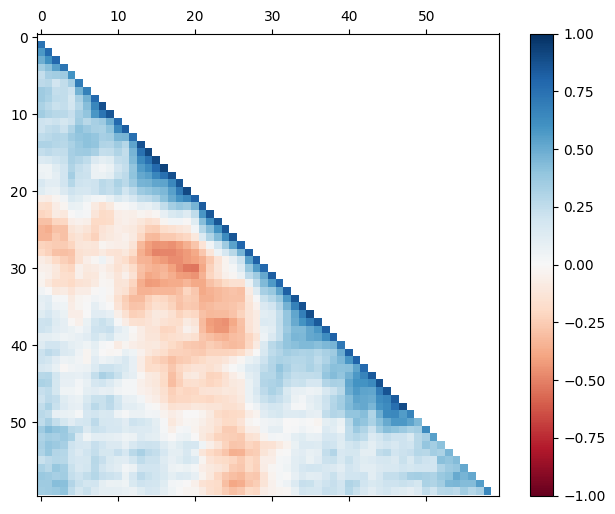

In [17]:
numeric_df = df.select_dtypes(include=['number']) # excluding target column from corr
corr_graph(numeric_df, False)

For more discussions about multicollinearity and feature reduction, see the last cells "Extra Topic - What about multicollinearity?"

### 3. Prepare Data

#### a) Data Cleaning

In [19]:
#All the values are numerical. Therefore, no cleaning is required!
# Check for NaN values
total_nan = df.isna().sum().sum()
print(f"Total NaN values in the dataset: {total_nan}")

Total NaN values in the dataset: 0


#### b) Feature Selection

In [91]:
# for this project, I will not to do it (For more discussions about multicollinearity and feature reduction, see the last cells "Extra Topic - What about multicollinearity?")

#### c) Data Transform

In [21]:
# for this dataset, we don't need to do it

### 4. Evaluate Algorithms

#### a) Split-out validation dataset

In [22]:
# Split-out validation dataset
array = df.values
X = array[:,0:-1].astype(float)
Y = array[:,-1]
validation_size = 0.2
seed = 7
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=validation_size, random_state=seed)

#### b) Test options and evaluation metric

In [23]:
# Test options and evaluation metric
num_folds = 10
scoring = 'accuracy'

#### c) Spot check Algorithms

In [24]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=1000)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='scale')))

In [87]:
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.771691 (0.091002)
LDA: 0.778676 (0.093570)
KNN: 0.758824 (0.106417)
CART: 0.727574 (0.102513)
NB: 0.682721 (0.136040)
SVM: 0.765074 (0.087519)


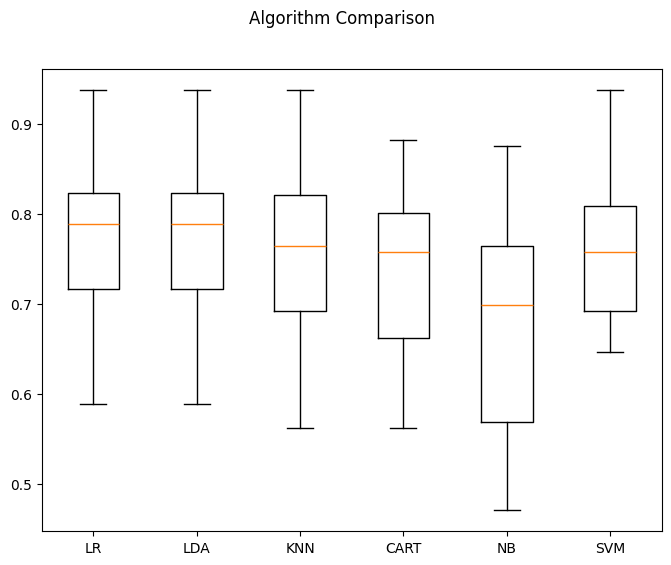

In [88]:
# compare algorithms

#plot boxplot
fig = plt.figure(figsize=(8, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- In terms of average and variance LR, LDA, and SVM performed better.

- KNN, CART, and NB showed the worst performance.

In [92]:
# Standardize features by removing the mean and scaling to unit variance.
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(solver='lbfgs', max_iter=1000))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(gamma='scale'))])))

# Evaluate algorithms on scaled dataset
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s:   mean: %f     std: %f' %(name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR:   mean: 0.754412     std: 0.067926
ScaledLDA:   mean: 0.778676     std: 0.093570
ScaledKNN:   mean: 0.808456     std: 0.107996
ScaledCART:   mean: 0.744485     std: 0.122678
ScaledNB:   mean: 0.682721     std: 0.136040
ScaledSVM:   mean: 0.826103     std: 0.081814


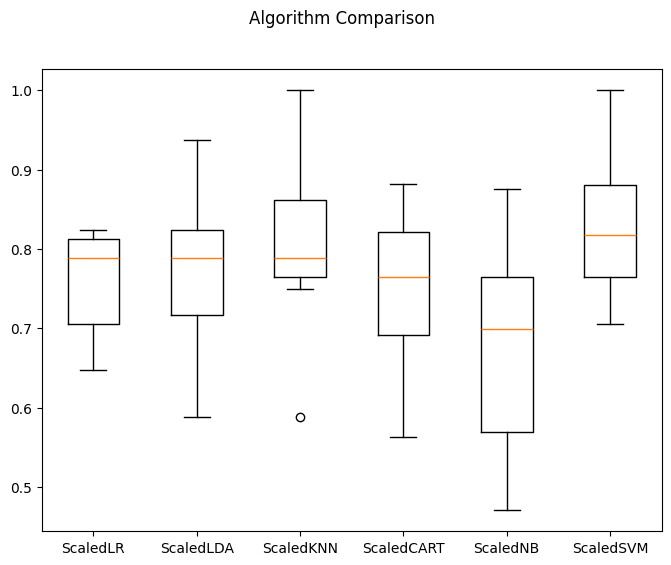

In [28]:
# compare algorithms

#plot boxplot
fig = plt.figure(figsize=(8, 6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

After standardizing the features:

- LR, LDA, CART, and NB did not show improvement.
- On the other hand, KNN and SVM achieved better results, even outperforming the best unstandardized models. These two models were chosen for further optimization to improve accuracy in the next section.

### 5. Improve Accuracy

#### a) Algorithm Tuning

KNN Best Score: 0.8360 using {'n_neighbors': np.int64(1)}
0.8360 (+/-0.0795) with: {'n_neighbors': np.int64(1)}
0.7949 (+/-0.1153) with: {'n_neighbors': np.int64(2)}
0.8136 (+/-0.0880) with: {'n_neighbors': np.int64(3)}
0.7963 (+/-0.1109) with: {'n_neighbors': np.int64(4)}
0.8143 (+/-0.0969) with: {'n_neighbors': np.int64(5)}
0.7474 (+/-0.1235) with: {'n_neighbors': np.int64(6)}
0.7776 (+/-0.1204) with: {'n_neighbors': np.int64(7)}
0.7353 (+/-0.1062) with: {'n_neighbors': np.int64(8)}
0.7301 (+/-0.0994) with: {'n_neighbors': np.int64(9)}
0.7235 (+/-0.0933) with: {'n_neighbors': np.int64(10)}
0.7415 (+/-0.0740) with: {'n_neighbors': np.int64(11)}
0.7294 (+/-0.0939) with: {'n_neighbors': np.int64(12)}
0.7107 (+/-0.1058) with: {'n_neighbors': np.int64(13)}
0.7110 (+/-0.0972) with: {'n_neighbors': np.int64(14)}
0.7232 (+/-0.0810) with: {'n_neighbors': np.int64(15)}
0.7048 (+/-0.0753) with: {'n_neighbors': np.int64(16)}
0.6989 (+/-0.0727) with: {'n_neighbors': np.int64(17)}
0.6989 (+/-0.091

c:\Users\kajin\workspace\sonar\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


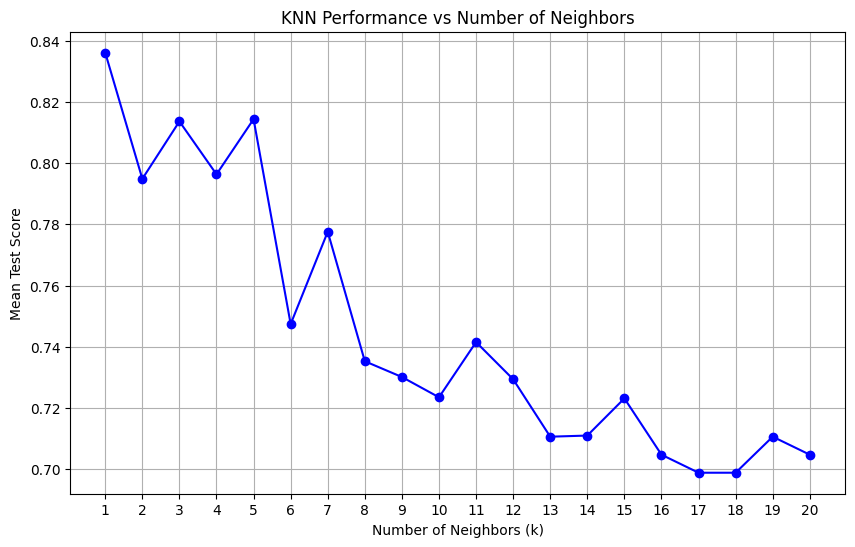

In [105]:
# Tuning KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.arange(1, 21)
param_grid = dict(n_neighbors=k_values)
model = KNeighborsClassifier()
kfold = KFold(n_splits = num_folds, random_state = seed, shuffle = True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print(f"KNN Best Score: {grid_result.best_score_:.4f} using {grid_result.best_params_}")

best_k_knn = grid_result.best_params_

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.4f} (+/-{stdev:.4f}) with: {param}")

# Extracting the 'n_neighbors' values from each dictionary
n_neighbors_values = [param['n_neighbors'] for param in params]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_neighbors_values, means, marker='o', linestyle='-', color='b')
plt.title('KNN Performance vs Number of Neighbors')
plt.ylabel('Mean Test Score')
plt.xlabel('Number of Neighbors (k)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [114]:
# Tuning SVM

# Tuning scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C = c_values, kernel = kernel_values)

model = SVC(gamma='scale')
kfold = KFold(n_splits = num_folds, random_state = 1235, shuffle = True)

grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring=scoring, cv=kfold, return_train_score=False)
grid_result = grid.fit(rescaledX, Y_train)
print(f"SVM Best Score: {grid_result.best_score_:.4f} using {grid_result.best_params_}")

best_params_svm = grid_result.best_params_

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.4f} (+/-{stdev:.4f}) with: {param}")

SVM Best Score: 0.8500 using {'C': 1.7, 'kernel': 'rbf'}
0.7776 (+/-0.0937) with: {'C': 0.1, 'kernel': 'linear'}
0.5930 (+/-0.1557) with: {'C': 0.1, 'kernel': 'poly'}
0.5136 (+/-0.1172) with: {'C': 0.1, 'kernel': 'rbf'}
0.7055 (+/-0.0818) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.7658 (+/-0.1214) with: {'C': 0.3, 'kernel': 'linear'}
0.6581 (+/-0.1244) with: {'C': 0.3, 'kernel': 'poly'}
0.7063 (+/-0.1028) with: {'C': 0.3, 'kernel': 'rbf'}
0.7651 (+/-0.0840) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.7662 (+/-0.1191) with: {'C': 0.5, 'kernel': 'linear'}
0.7246 (+/-0.1363) with: {'C': 0.5, 'kernel': 'poly'}
0.7658 (+/-0.0769) with: {'C': 0.5, 'kernel': 'rbf'}
0.7654 (+/-0.0921) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.7599 (+/-0.1178) with: {'C': 0.7, 'kernel': 'linear'}
0.7728 (+/-0.1165) with: {'C': 0.7, 'kernel': 'poly'}
0.8018 (+/-0.0968) with: {'C': 0.7, 'kernel': 'rbf'}
0.7592 (+/-0.0990) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.7717 (+/-0.1176) with: {'C': 0.9, 'kernel': 'linear'}
0.8077 

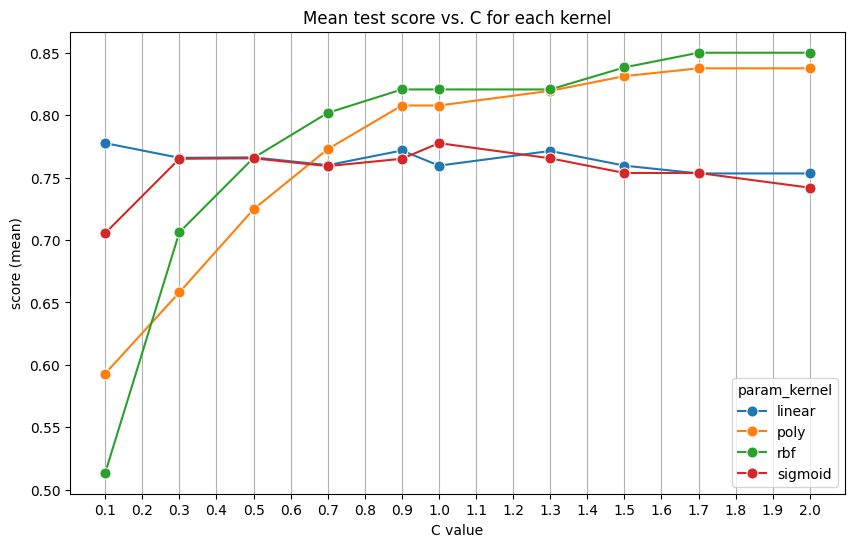

In [101]:
results_df = pd.DataFrame(grid_result.cv_results_)
selected_results_df = results_df[['mean_test_score', 'param_C', 'param_kernel']]

# Plotting
plt.figure(figsize=(10, 6))
plt.title('Mean test score vs. C for each kernel')
sns.lineplot(data=selected_results_df, x='param_C', y='mean_test_score', hue='param_kernel', marker='o', markersize=8)
plt.grid(axis='x')
plt.xticks(np.arange(0.1, 2.1, 0.1))
plt.ylabel('score (mean)')
plt.xlabel('C value')
plt.show()

Best parameters
- KNN Best Score: 0.8360 using {'n_neighbors': 1}
- SVM Best Score: 0.8500 using {'C': 1.7, 'kernel': 'rbf'}

#### b) Ensembles

In [111]:
# ensemble KNN

# Best n_neighbors from previous KNN tuning
best_k = best_k_knn['n_neighbors']
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)

ensembles = []
ensembles.append(('AB', AdaBoostClassifier(algorithm='SAMME')))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))

results = []
names = []

for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    print(f"Model {name}: mean: {cv_results.mean():.4f} std: {cv_results.std():.4f}")

Model AB: mean: 0.8018 std: 0.0873
Model GBM: mean: 0.8018 std: 0.1319
Model RF: mean: 0.7412 std: 0.1198
Model ET: mean: 0.7949 std: 0.0946


In [33]:
# ensemble SVM
ensembles = []
ensembles.append(('AB', AdaBoostClassifier(algorithm='SAMME')))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Model %s:   mean: %f   std: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)


# Tuning scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

param_grid = dict(C = c_values, kernel = kernel_values)
model = SVC(gamma = 'auto')
kfold = KFold(n_splits = num_folds, random_state = 1235, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid=param_grid, scoring=scoring, cv=kfold, return_train_score=False)
grid_result = grid.fit(rescaledX, Y_train)
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

Model AB:   mean: 0.801838   std: 0.087303
Model GBM:   mean: 0.795956   std: 0.129819
Model RF:   mean: 0.777574   std: 0.090791
Model ET:   mean: 0.838603   std: 0.057014
Best: 0.850000 using {'C': 1.7, 'kernel': 'rbf'}
0.777574 (0.093692) with: {'C': 0.1, 'kernel': 'linear'}
0.587132 (0.159077) with: {'C': 0.1, 'kernel': 'poly'}
0.513603 (0.117210) with: {'C': 0.1, 'kernel': 'rbf'}
0.705515 (0.081787) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.765809 (0.121435) with: {'C': 0.3, 'kernel': 'linear'}
0.651838 (0.121190) with: {'C': 0.3, 'kernel': 'poly'}
0.706250 (0.102763) with: {'C': 0.3, 'kernel': 'rbf'}
0.771324 (0.084970) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.766176 (0.119088) with: {'C': 0.5, 'kernel': 'linear'}
0.724632 (0.127415) with: {'C': 0.5, 'kernel': 'poly'}
0.771691 (0.083050) with: {'C': 0.5, 'kernel': 'rbf'}
0.759191 (0.086381) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.759926 (0.117751) with: {'C': 0.7, 'kernel': 'linear'}
0.784926 (0.126593) with: {'C': 0.7, 'kernel': 'p

The SVM demonstrated great potential as a stable and low-complexity model for this problem. One key observation was that SVM achieves better performance when the dataset is standardized, ensuring that all attributes have a mean of zero and a standard deviation of one.
- Unfortunately, both ensemble models perform worse. Ensembles do not always guarantee better results.
- The best result was SVM classifier with C=1.7 and kernel=rbf with 0,85% average score.

In the next section, we will finalize the model by training it on the full training dataset and making predictions on the hold-out validation set to validate our findings.

### 6. Finalize Model

#### a) Predictions on validation dataset

In [129]:
# Prepare the SVM model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

model = SVC(gamma='scale', random_state = 1235, C = best_params_svm['C'], kernel = best_params_svm['kernel'])
model.fit(rescaledX, Y_train)

SVC(C=1.7, random_state=1235)

#### b) Create standalone model on entire training dataset

In [128]:
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_val)
predictions = model.predict(rescaledValidationX)
print(accuracy_score(Y_val, predictions))
print(confusion_matrix(Y_val, predictions))
print(classification_report(Y_val, predictions))

0.9285714285714286
[[25  2]
 [ 1 14]]
              precision    recall  f1-score   support

           M       0.96      0.93      0.94        27
           R       0.88      0.93      0.90        15

    accuracy                           0.93        42
   macro avg       0.92      0.93      0.92        42
weighted avg       0.93      0.93      0.93        42



We can see that we achieve an accuracy of nearly 86% on the held-out validation dataset. A score that matches closely to our expectations estimated above during the tuning of SVM.

We achieved an accuracy of approximately 93% on the validation dataset, indicating strong model performance. The confusion matrix shows that out of 27 instances of class 'M', the model correctly predicted 25, with only 2 misclassifications. Similarly, for class 'R', it correctly predicted 14 out of 15 instances, with only 1 misclassification.

The classification report further reinforces these results:

- Precision for class 'M' is 0.96, meaning that 96% of the instances predicted as 'M' are correct.
- Recall for class 'M' is 0.93, showing that the model successfully identified 93% of the actual 'M' instances.
- For class 'R', the precision and recall are 0.88 and 0.93, respectively, which shows slightly lower precision but equally good recall.
- Overall, the f1-scores of 0.94 for class 'M' and 0.90 for class 'R** suggest a well-balanced model performance, especially given the class distribution in the validation set. These results align with our expectations based on the SVM tuning phase, confirming the stability and effectiveness of the model.

#### c) Save model for later use

In [133]:
# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

## Extra Topic - What about multicollinearity?

Where a feature exhibits a linear relationship with two or more features. Possible remedy to multicollinearity problem: Remove some of the highly correlated features
- Manual Method - Variance Inflation Factor (VIF) - can't be used for classificantion
- Automatic Method - Recursive Feature Elimination (RFE)
- Feature Elmination using PCA Decomposition

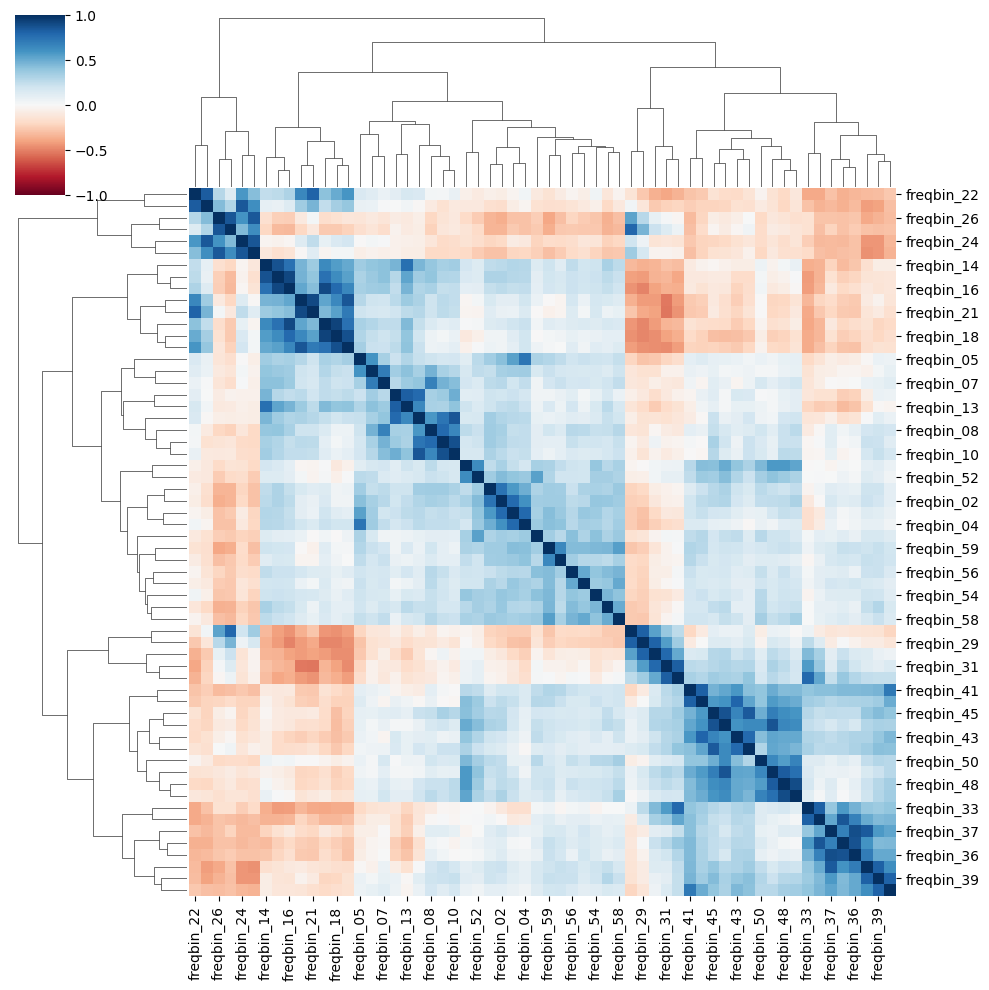

In [ ]:
# Clustermap table shows not only all correlation between variables, but also group (cluster) relationships.
clustermap = sns.clustermap(numeric_df.corr(), vmin = -1, vmax = 1, cmap='RdBu', annot = False)

In [ ]:
# VIF
X = numeric_df
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_df.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

# As a rule of thumb, a VIF value that exceeds 5 or 10 indicates a problematic amount of collinearity
vif_data.head()

,Feature,VIF
0,freqbin_01,8.415814
1,freqbin_02,13.166842
2,freqbin_03,16.145169
3,freqbin_04,15.347698
4,freqbin_05,14.091123


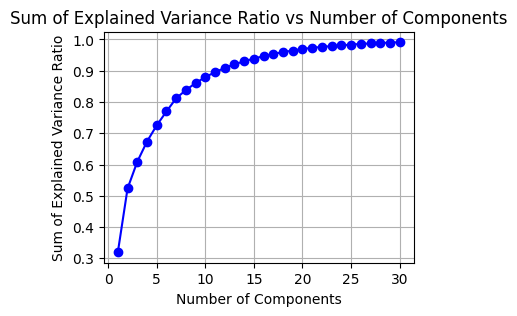

In [ ]:
# PCA

array = df.values
X = array[:,0:-1].astype(float)
Y = array[:,-1]

# Initialize lists to store the number of components and explained variance sum
components = list(range(1, 31))
explained_variance_sums = []

# Iterate over the range of n_components
for n in components:
    pca = PCA(n_components=n)
    pca_fit = pca.fit(X)
    explained_variance_sums.append(pca_fit.explained_variance_ratio_.sum())

# Plotting
plt.figure(figsize=(4, 3))
plt.plot(components, explained_variance_sums, marker='o', linestyle='-', color='b')
plt.title('Sum of Explained Variance Ratio vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Sum of Explained Variance Ratio')
plt.grid(True)
plt.show()

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(model)
rfe_fit = rfe.fit(X, Y)

print("Num Features: %d" % rfe_fit.n_features_)
print("Selected Features: %s" % rfe_fit.support_)
print("Feature Ranking: %s" % rfe_fit.ranking_)

# maping scores to the attribute names
selected_col_indices = np.where(rfe_fit.support_)[0]
selected_col_name_list = [df.columns[i] for i in selected_col_indices]
print(selected_col_name_list)

Num Features: 30
Selected Features: [False False False  True  True False False False  True  True  True  True
  True False False  True  True False False  True  True  True  True False
 False False False  True False  True  True False False False  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True False False False False False False False False False False False]
Feature Ranking: [ 9  2  7  1  1 18 17 31  1  1  1  1  1 30  4  1  1 12 10  1  1  1  1  8
 11  5 22  1  6  1  1 13 25  3  1  1  1  1  1  1 15  1  1  1  1  1  1  1
  1 27 14 16 23 19 29 26 28 21 20 24]
['freqbin_04', 'freqbin_05', 'freqbin_09', 'freqbin_10', 'freqbin_11', 'freqbin_12', 'freqbin_13', 'freqbin_16', 'freqbin_17', 'freqbin_20', 'freqbin_21', 'freqbin_22', 'freqbin_23', 'freqbin_28', 'freqbin_30', 'freqbin_31', 'freqbin_35', 'freqbin_36', 'freqbin_37', 'freqbin_38', 'freqbin_39', 'freqbin_40', 'freqbin_42', 'freqbin_43', 'freqbin_44', 'freqbin_45', 'freqbin_46', 'freqbin_47', 'fre